In [1]:
import sys
import time

sys.path.insert(0, '..')

import torch
import numpy as np
import torchvision
from torchvision import transforms
from tqdm.notebook import tqdm

from dataset.dataloader import TorchLoader
from net.intermediate import IntermediateNetwork
from net.ssd import SSD300, MultiBoxLoss
from utils.obj_utils import cxcy_to_xy, cxcy_to_gcxgcy, xy_to_cxcy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

In [2]:
coco_root = 'coco_data/'
coco = torchvision.datasets.coco.CocoDetection(root=coco_root + 'val/val2017/', annFile=coco_root + 'annotations/instances_val2017.json')

loading annotations into memory...
Done (t=0.32s)
creating index...
index created!


In [3]:
resnet = IntermediateNetwork('resnet50', [5, 6]).to(device)
ssd_net = SSD300(resnet, 90 + 1).to(device)

In [4]:
start_lr = 0.1
momentum = 0.9
weight_decay = 5e-4
optimizer = torch.optim.SGD(ssd_net.parameters(), lr=start_lr, momentum=momentum, weight_decay=weight_decay)
priors = ssd_net.priors_cxcy.to(device)
criterion = MultiBoxLoss(priors_cxcy=priors)

/home/sixigma/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [5]:
coco_transform = transforms.Compose([transforms.Resize((300, 300)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
batch_size = 16
images = []

In [6]:
def collate_fn_coco(batch):
    images, annos = tuple(zip(*batch))
    t_images = torch.empty((0, 3, 300, 300))
    b_bboxes = []
    b_labels = []
    for i, image in enumerate(images):
        labels = []
        bboxes = []
        r_width = 1 / image.size[0]
        r_height = 1 / image.size[1]
        t_image = torch.unsqueeze(coco_transform(image), dim=0)
        t_images = torch.cat((t_images, t_image))
        for anno in annos[i]:
            bbox = [anno['bbox'][0] * r_width, anno['bbox'][1] * r_height, 
                    (anno['bbox'][0] + anno['bbox'][2]) * r_width, (anno['bbox'][1] + anno['bbox'][3]) * r_height]
            bboxes.append(bbox)
            labels.append(anno['category_id'])
        b_bboxes.append(torch.tensor(bboxes))
        b_labels.append(torch.tensor(labels))
        
    return t_images, b_bboxes, b_labels

In [7]:
sampler = torch.utils.data.RandomSampler(coco)
batch_sampler = torch.utils.data.BatchSampler(sampler, batch_size, drop_last=True)
 
data_loader = torch.utils.data.DataLoader(
        coco, batch_sampler=batch_sampler, num_workers=4,
        collate_fn=collate_fn_coco, pin_memory=True)

In [8]:
start_time = time.time()
losses = []
inference_bbox = []
inference_prob = []
eval_img = None
num_epoch = 20
for e in tqdm(range(num_epoch)):
    with tqdm(data_loader) as data_loader_bar:
        for i, (imgs, b_bboxes, b_labels) in enumerate(data_loader_bar):
            if eval_img is None:
                eval_img = torch.unsqueeze(imgs[0], dim=0)
                eval_boxes = b_bboxes[0]
                eval_labels = b_labels[0]
            pred_locs, pred_cls_prob = ssd_net(imgs.to(device))

            for b in range(len(b_bboxes)):
                b_bboxes[b] = b_bboxes[b].to(device)
                b_labels[b] = b_labels[b].to(device)

            loss = criterion(pred_locs.to(device), pred_cls_prob.to(device), b_bboxes, b_labels)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
        data_loader_bar.close()
    
    losses.append(loss)
    del pred_locs, pred_cls_prob, loss
    with torch.no_grad():
        eval_locs, eval_prob = ssd_net(eval_img.to(device))
        inference_bbox.append(eval_locs)
        inference_prob.append(eval_prob)
print('Training takes', time.time() - start_time)



Training takes 1280.1033670902252


In [17]:
box = []
label = []
score = []
for pred_bbox, pred_prob in zip(inference_bbox, inference_prob):
    b, l, s = ssd_net.detect_objects(pred_bbox, pred_prob, 0.1, 0.9, 3)
    box.append(b); label.append(l); score.append(s)
box, label, score

([[tensor([[0.1105, 0.1492, 0.9230, 0.9191],
           [0.1249, 0.1159, 0.9023, 0.8997],
           [0.2248, 0.1002, 0.8513, 0.9605]], device='cuda:0')],
  [tensor([[0.0621, 0.1431, 0.9035, 0.8710]], device='cuda:0')],
  [tensor([[0., 0., 1., 1.]], device='cuda:0')],
  [tensor([[0.0503, 0.1547, 0.8859, 0.9108],
           [0.0868, 0.1444, 0.8787, 0.8560],
           [0.0548, 0.1978, 0.9377, 0.8293]], device='cuda:0')],
  [tensor([[0., 0., 1., 1.]], device='cuda:0')],
  [tensor([[0.1881, 0.3321, 0.6982, 0.7840],
           [0.1110, 0.3490, 0.6364, 0.7979],
           [0.2573, 0.3340, 0.7934, 0.7893]], device='cuda:0')],
  [tensor([[0.0810, 0.3493, 0.5766, 0.9357],
           [0.5369, 0.4965, 0.9819, 0.9737],
           [0.1762, 0.2974, 0.6980, 0.8064]], device='cuda:0')],
  [tensor([[0., 0., 1., 1.]], device='cuda:0')],
  [tensor([[0.1178, 0.0671, 0.2087, 0.1204],
           [0.1460, 0.0544, 0.1943, 0.1190],
           [0.6887, 0.9490, 0.7320, 1.0104]], device='cuda:0')],
  [tensor([[0

In [13]:
eval_boxes, eval_labels

(tensor([[0.0253, 0.2051, 0.9411, 0.7733]]), tensor([5]))

In [14]:
losses

[tensor(63.0558, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(344.9848, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(215.3725, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(229.2771, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(169.7345, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(173.4576, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(66.3039, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(107.6308, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(78.7839, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(115.8531, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(72.5062, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(50.7709, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(159.9846, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(103.8143, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(220.7781, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(157.3498, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(374.5132, device='cuda:0', grad_fn=<A

In [37]:
from PIL import Image
import numpy as np
_eval_img = (eval_img[0].permute(1, 2, 0).numpy() * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255

<Figure size 432x288 with 0 Axes>

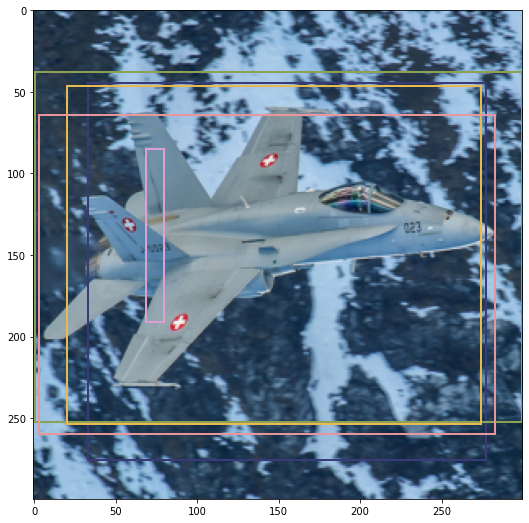

In [38]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(np.array(_eval_img, dtype=np.uint8))

cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 5)]

width, height = (300, 300)
for i in range(5):
    obj = np.array(box[-i][0][torch.argmax(score[-i][0])].cpu())
    x = obj[0] * width
    y = obj[1] * height
    box_w = (obj[2] - obj[0]) * width
    box_h = (obj[3] - obj[1]) * height
    bbox = patches.Rectangle((x, y), box_w, box_h,
             linewidth=2, edgecolor=colors[i], facecolor='none')
    ax.add_patch(bbox)